# Malaria disease Classification using EfficientNet in pytorch


## Datasets

We have total of a total of 27,558 images containing Infected & Uninfected data.



# Import base libraries 

In [23]:
import os
import glob
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from PIL import Image
from skimage.transform import resize
from skimage.io import imshow
from tqdm.notebook import tqdm
%matplotlib inline

In [19]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
#https://www.fast.ai/
#fastai code snippet
class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
def imshow_transform(image_in, title=None):
    """Imshow for Tensor."""
    img = np.rollaxis(image_in.squeeze().cpu().detach().numpy(),0,3)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    return img

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# Preparing the Data
Creating PyTorch datasets to load the data.

In [3]:
base_dir = os.path.join('./data/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_data = glob.glob(infected_dir+'/*.png')
healthy_data = glob.glob(healthy_dir+'/*.png')
print (len(infected_data), len(healthy_data))


13779 13779


## Data view & Dataframe
Now, we have a balanced dataset with 13,779 malaria and 13,779 non-malaria (uninfected) cell images. 
Build a data frame from this, which is used later.


In [4]:
datafiles = infected_data + healthy_data
print (len(datafiles))

27558


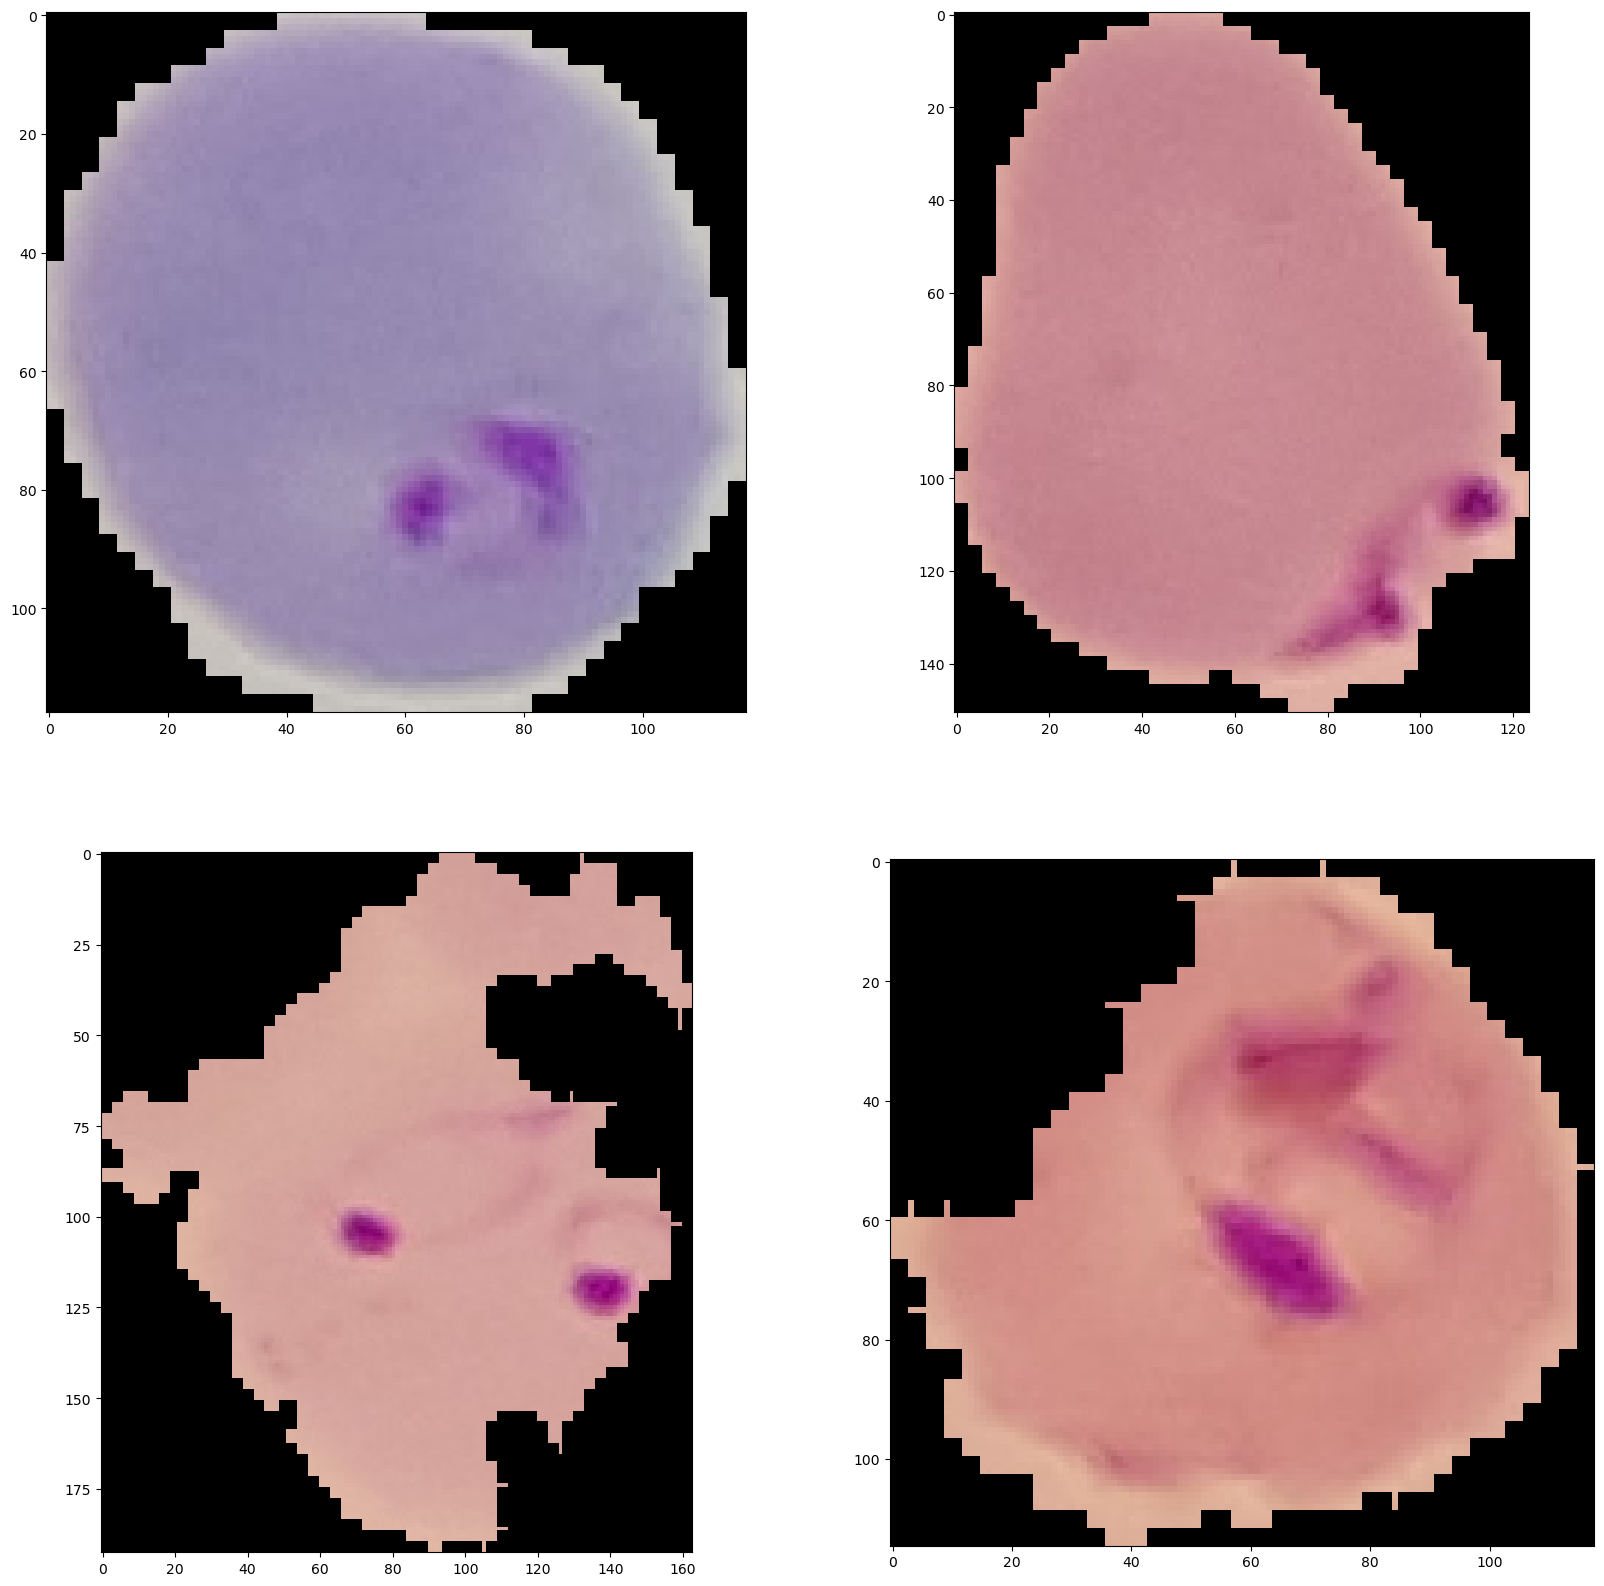

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
for i in range(4):
    img = plt.imread(datafiles[i])
    ax=axes[i//2,i%2]
    ax.imshow(img) 

# Convert images into tensors and reshaping it

In [6]:
#spiting the data into train and validation
torch.manual_seed(43)
val_size = int (len(datafiles) * 0.2)
train_size = len(datafiles) - val_size
print (train_size , val_size)

22047 5511


# Data transforms (normalization & data augmentation)

In [7]:
total_dataset = tt.Compose([tt.Resize((224,224)),
    tt.ColorJitter(0.05),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    tt.RandomRotation(25),
    tt.ToTensor(),
    tt.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])]) ##about mean and standard deviation per channel

In [8]:
# PyTorch datasets
total_dataset = ImageFolder(base_dir, total_dataset)
train_dt, valid_dt = random_split(total_dataset, [train_size, val_size])
batch_size=16 ##define the total number of batch size
train_dataset = DataLoader(train_dt, batch_size=batch_size,shuffle=True, num_workers=3, pin_memory=True)
valid_dataset = DataLoader(valid_dt, batch_size=batch_size * 2,num_workers=3, pin_memory=True)
print("Number of batches in train set: {}\nNumber of batches in validation set: {}".format(len(train_dataset), len(valid_dataset)))

Number of batches in train set: 1378
Number of batches in validation set: 173


In [9]:
def show_batch(datast):
    for imgs, labs in datast:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(imgs[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


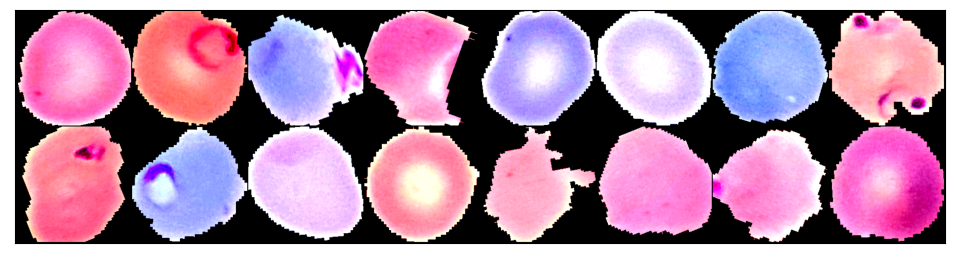

In [10]:
show_batch(train_dataset)

In [11]:
classes=['infected','uninfected']

## Using a GPU
Function to support GPU if possible

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [14]:
train_dataset = DeviceDataLoader(train_dataset, device)
valid_dataset = DeviceDataLoader(valid_dataset, device)

## Training and Validation

In [15]:
 def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
 def F_score(output, label, threshold=0.5, beta=1):
    _, prob = torch.max(output, dim=1)

    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [16]:
class Classification(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.model=EfficientNet.from_pretrained('efficientnet-b0')
        self.model._fc=nn.Linear(1280,2)
        
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)      
        loss = F.cross_entropy(out, targets)      
        return loss
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, targets) 
        acc = accuracy(out,targets)
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc,'f1_score': score}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        batch_scores = [x['val_acc'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        batch_f1_scores = [x['f1_score'] for x in outputs]
        epoch_f1_score = torch.stack(batch_f1_scores).mean()  # Combine f1_score
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_score.item(), 'f1_score': epoch_f1_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, val_f1_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc'],result['f1_score']))
        
    def forward(self, x):
        out = self.model(x)
        return out
    

In [16]:
model = Classification()
model.to(device)

Loaded pretrained weights for efficientnet-b0


Classification(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, opt_func=torch.optim.SGD,epochs=5, lr=0.0001):
    torch.cuda.empty_cache()
    history_information = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history_information.append(result)
    return history_information

In [18]:
num_epochs = 10
optimizer = torch.optim.Adam
learning_rate = 1e-4

In [19]:
history_information = fit(model, train_dataset, valid_dataset, optimizer,num_epochs, learning_rate)

  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1306, val_loss: 0.0953, val_accuracy: 0.9675, val_f1_score: 0.9666


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0907, val_loss: 0.0804, val_accuracy: 0.9716, val_f1_score: 0.9707


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0800, val_loss: 0.0826, val_accuracy: 0.9702, val_f1_score: 0.9700


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0732, val_loss: 0.0741, val_accuracy: 0.9747, val_f1_score: 0.9745


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0669, val_loss: 0.0806, val_accuracy: 0.9733, val_f1_score: 0.9731


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0665, val_loss: 0.0734, val_accuracy: 0.9742, val_f1_score: 0.9738


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0584, val_loss: 0.0757, val_accuracy: 0.9724, val_f1_score: 0.9722


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0579, val_loss: 0.0818, val_accuracy: 0.9698, val_f1_score: 0.9694


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0538, val_loss: 0.0719, val_accuracy: 0.9749, val_f1_score: 0.9746


  0%|          | 0/1378 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0520, val_loss: 0.0878, val_accuracy: 0.9688, val_f1_score: 0.9682


In [20]:
evaluate(model, valid_dataset)

{'val_loss': 0.08742663264274597,
 'val_acc': 0.9712789058685303,
 'f1_score': 0.9708026647567749}

## Visualizing the result

### Accuracy 

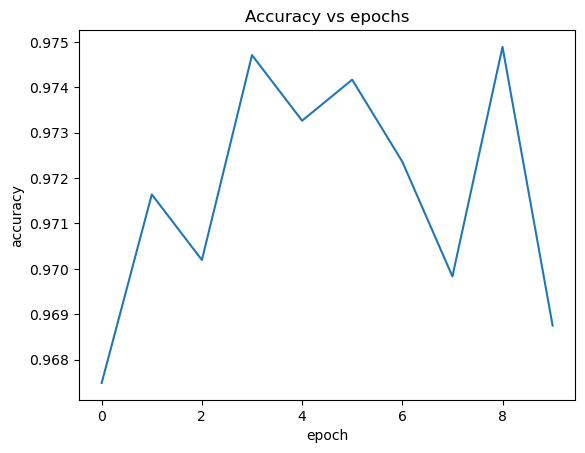

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs epochs');
plot_accuracies(history_information)

### Loss

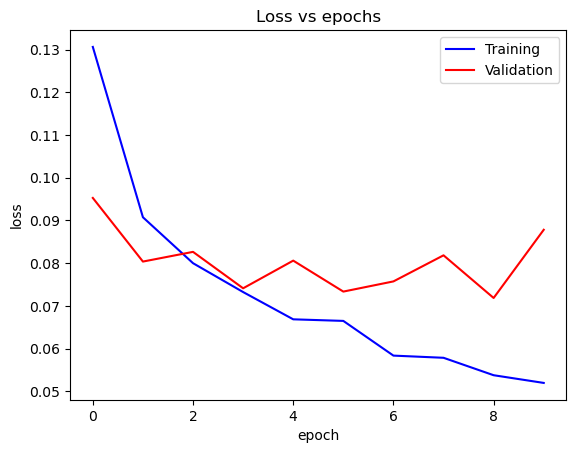

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs epochs');
plot_losses(history_information)

## Sava & Commit

In [24]:
torch.save(model.state_dict(), 'malaria_efficientnet.pth')

In [17]:
model = Classification()
#model.model._conv_head=nn.Conv2d(320,2,kernel_size=1, padding='same')
#model.model._bn1=nn.BatchNorm2d(2)
#model.model._dropout=Identity()
#model.model._fc=Flatten()
#model.model._swish=nn.Softmax()
state_dict = torch.load('./malaria_efficientnet.pth')
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Loaded pretrained weights for efficientnet-b0


Classification(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

result: infected 0


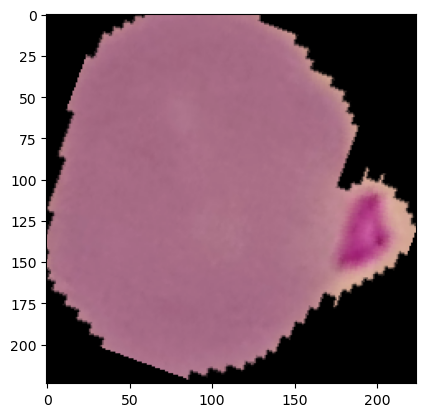

In [42]:
model.eval()
valid_dataset = DataLoader(valid_dt, batch_size=1,shuffle=True,num_workers=1, pin_memory=True)
#get the last convolution
lastfeature = SaveFeatures(model.model._conv_head)
#get image and label
image, label = next(iter(valid_dataset))
image = image.cuda()
label = label.cuda()

outputs = model.model(image)
result = torch.argmax(outputs).cpu().detach().numpy()

if result==1:
    print('result: not infected',result)
else:
    print('result: infected',result)
original_image=imshow_transform(image)

In [43]:
lastfeature.remove()
arr = lastfeature.features.cpu().detach().numpy()[0]
weight_softmax =model.model._fc.weight.data.cpu().numpy()

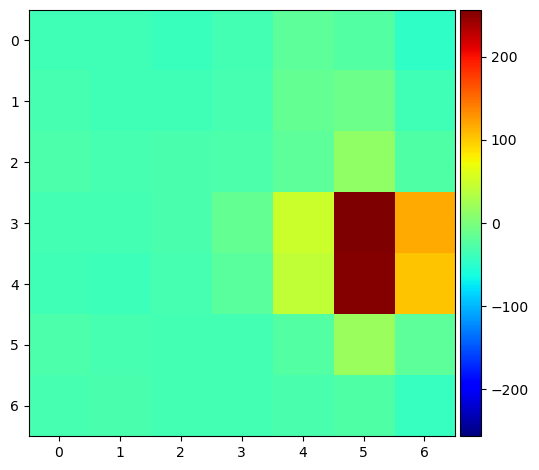

In [44]:
target=np.zeros([2,1]) ##for two classes
target[result]=1
cam_image = np.dot(np.rollaxis(arr,0,3), weight_softmax[result])
imshow(cam_image, cmap='jet')

<Figure size 640x480 with 0 Axes>

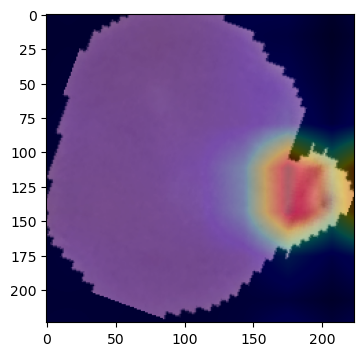

In [45]:
##resize the image and plot the cam
cam_image=resize(cam_image, (224,224))
plt.figure()
plt.subplots(figsize=(4,4))
plt.imshow(original_image)
plt.imshow(cam_image,alpha=.3, cmap='jet')
plt.show()

## References used :


Refrences :

1. https://opensource.com/article/19/4/detecting-malaria-deep-learning (using tensorflow2.0)

2. https://lhncbc.nlm.nih.gov/publication/pub9932 (original link for documentation & dataset)

3. https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce (to understsand image tranformation)

 